In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(n_sources=2000)
exposure = testObj.im1.asAfwExposure()

In [3]:
# for comparison:
def tmp(exposure):
    exp = exposure.clone()
    mi = exp.getMaskedImage()
    mi += 5.
    return exp

%timeit tmp(exposure)

1000 loops, best of 3: 236 µs per loop


In [5]:
import lsst.ip.diffim as ipDiffim
import testImageMapReduce as tig  # only works if you link from ip_diffim to ip_diffim/tests/testImageGridder.py
config = tig.AddAmountImageMapReduceConfig()

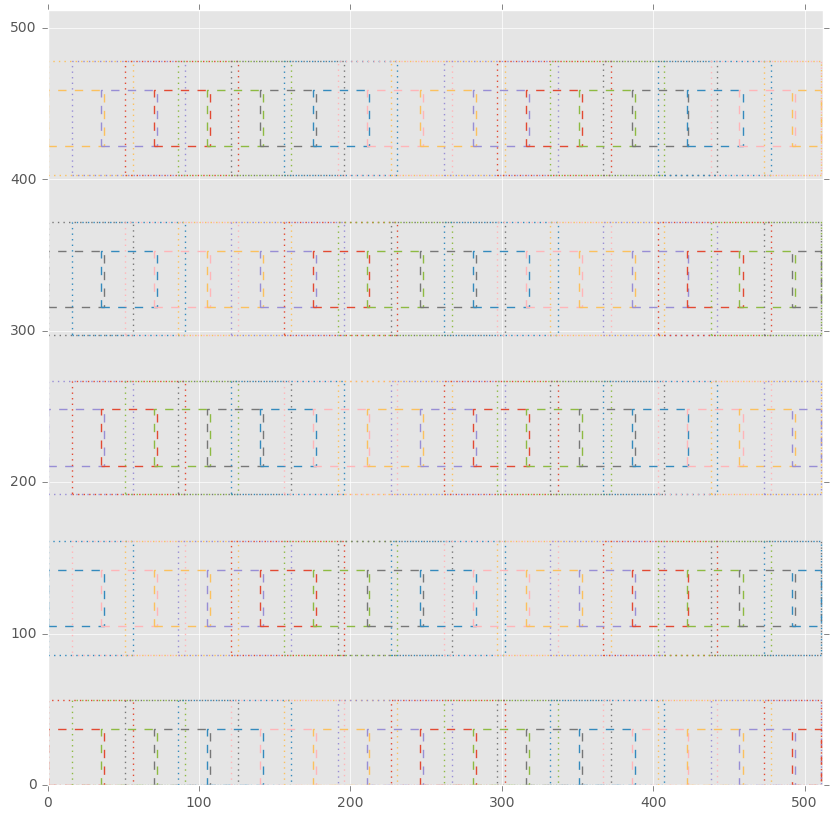

In [6]:
task = ipDiffim.ImageMapReduceTask(config=config)
plt.figure(figsize=(10,10))
task._plotBoxes(exposure);

In [7]:
newExp = task.run(exposure)  # this just adds 10 to the exposure

In [8]:
%timeit -n1 task.run(exposure)

1 loop, best of 3: 103 ms per loop


stats(mean=5.4581165, stdev=20.282354, min=-72.0, max=1879.0)
stats(mean=15.458117, stdev=20.282354, min=-62.0, max=1889.0)
stats(mean=-10.0, stdev=0.0, min=-10.0, max=-10.0)


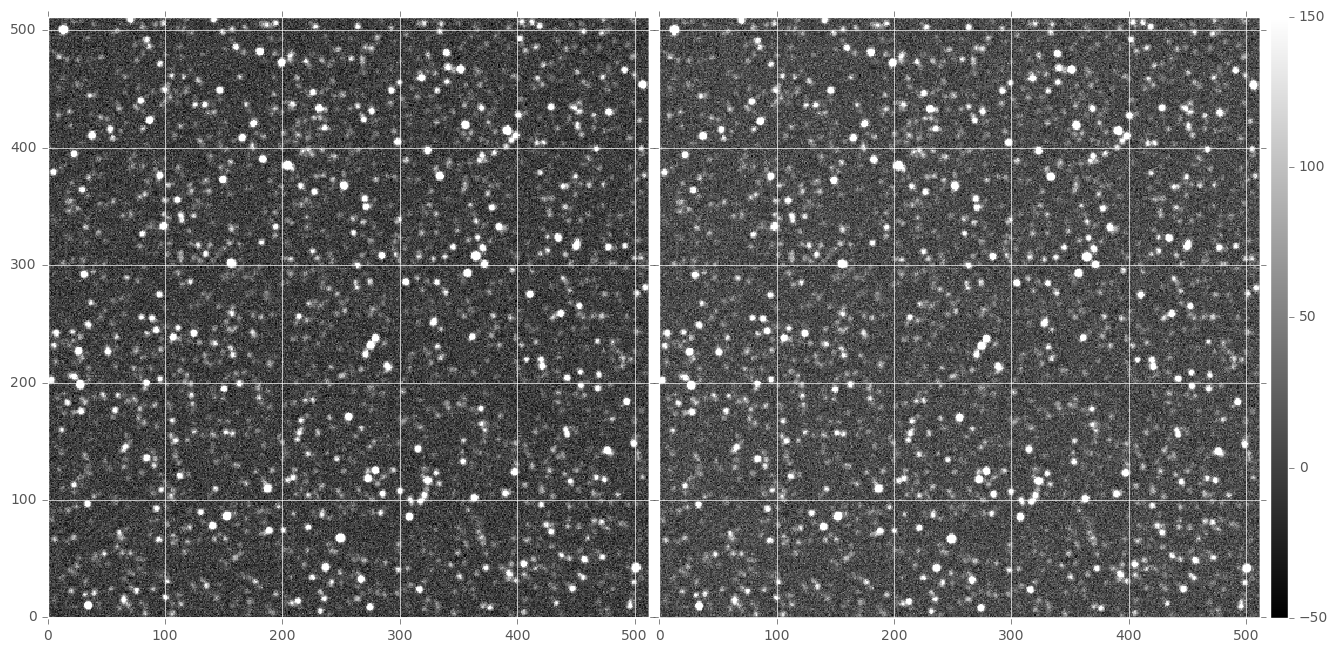

In [9]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), clim=(-50,150), imScale=8)

## Now test with overlapping cells

In [10]:
config = tig.AddAmountImageMapReduceConfig()
config.gridStepX = config.gridStepY = 8
config.mapperSubtask.addAmount = 20.  # change default from 10 to 20

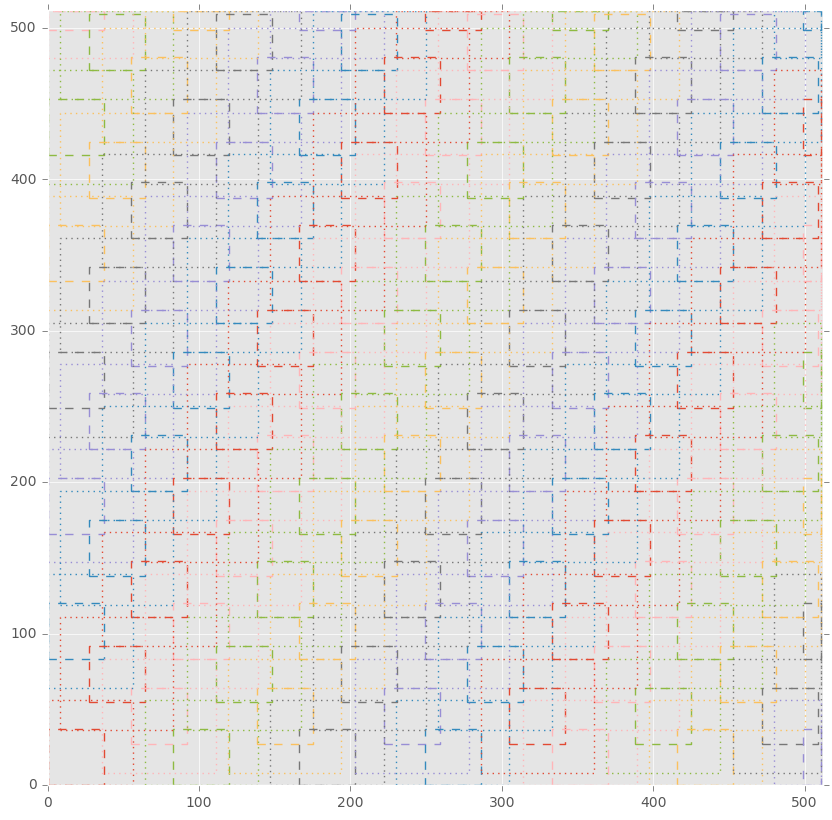

In [11]:
task = ipDiffim.ImageMapReduceTask(config=config)
plt.figure(figsize=(10,10))
task._plotBoxes(exposure);

In [12]:
newExp = task.run(exposure)  # this just adds 20 to the exposure

In [13]:
%timeit -n1 task.run(exposure)

1 loop, best of 3: 129 ms per loop


stats(mean=5.4581165, stdev=20.282354, min=-72.0, max=1879.0)
stats(mean=25.458117, stdev=20.282354, min=-52.0, max=1899.0)
stats(mean=-20.0, stdev=0.0, min=-20.0, max=-20.0)


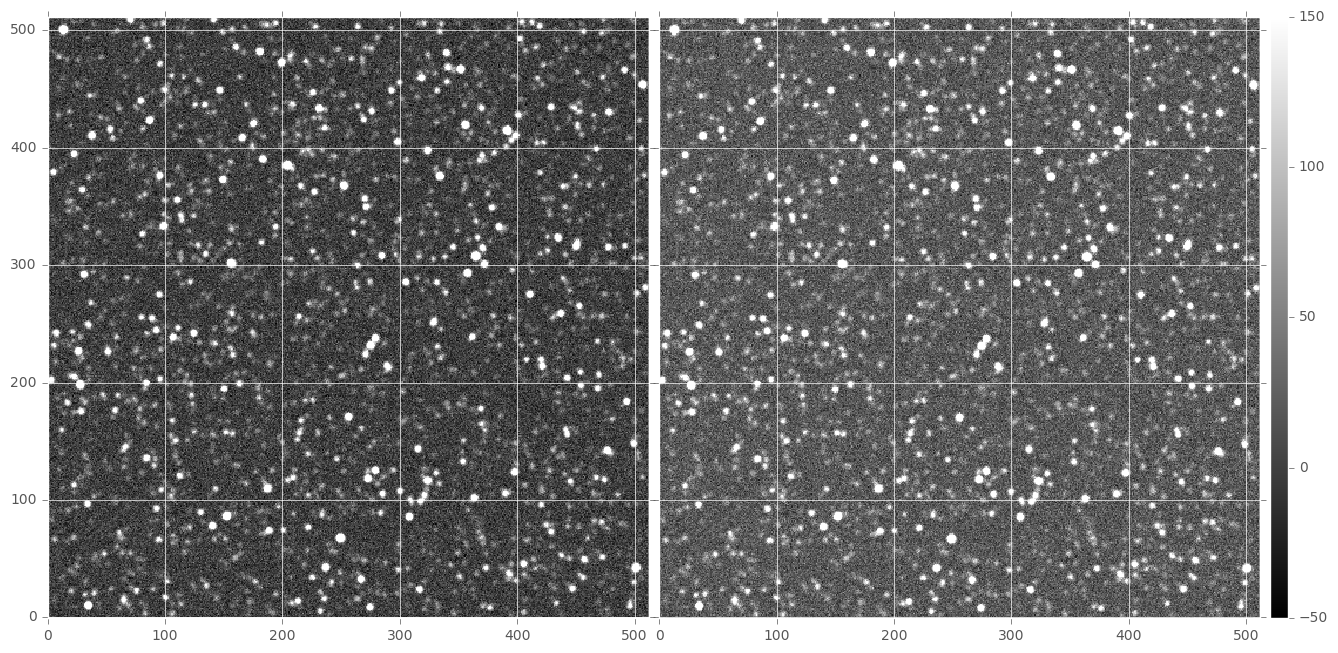

In [14]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), clim=(-50,150), imScale=8)

### Try new reduceOperation options...

First, 'sum'

In [15]:
config = tig.AddAmountImageMapReduceConfig()
config.gridStepX = config.gridStepY = 8
config.mapperSubtask.addAmount = 20.  # change default from 10 to 20

print config.reducerSubtask.reduceOperation
config.reducerSubtask.reduceOperation = 'sum'

copy


In [16]:
task = ipDiffim.ImageMapReduceTask(config=config)
newExp = task.run(exposure)  # this just adds 20 to the exposure but overlaps will be higher

stats(mean=5.4581165, stdev=20.282354, min=-72.0, max=1879.0)
stats(mean=42.417786, stdev=38.211937, min=-208.0, max=7176.0)
stats(mean=-33.840485, stdev=19.806744, min=-5402.0, max=136.0)


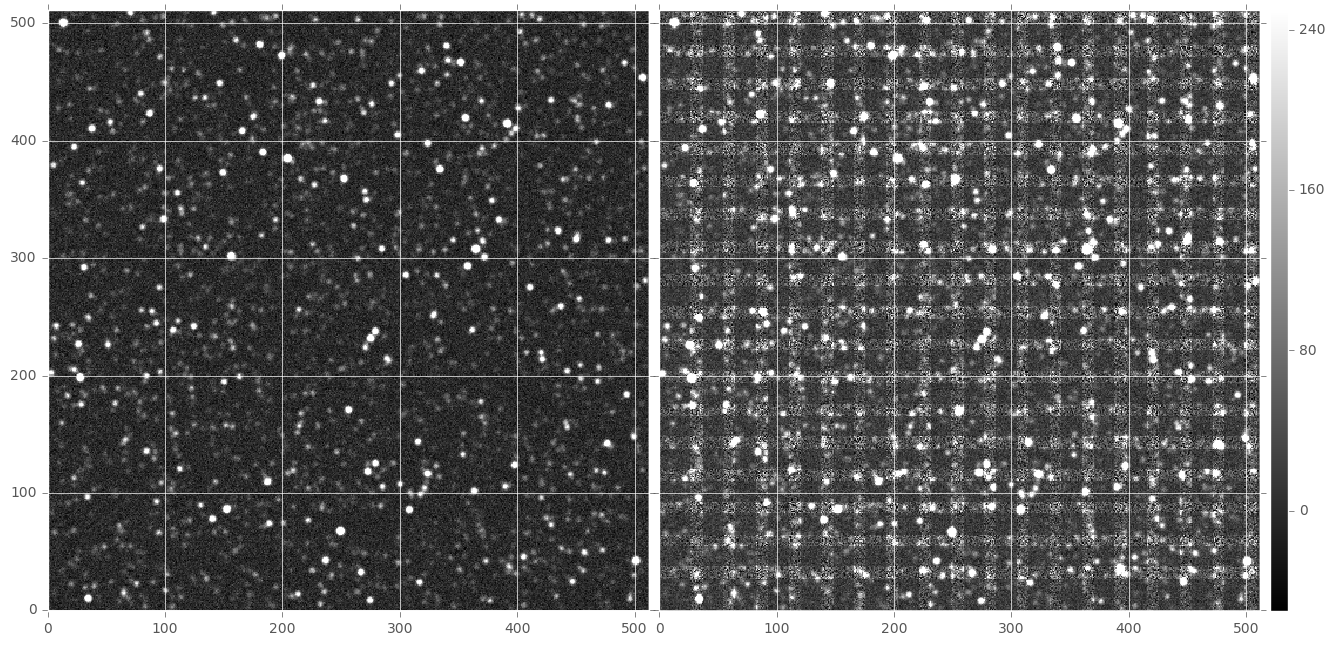

In [17]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), clim=(-50,250), imScale=8)

Try new 'average'

In [18]:
import lsst.ip.diffim as ipDiffim
#reload(ipDiffim)
config = tig.AddAmountImageMapReduceConfig()
config.gridStepX = config.gridStepY = 8
config.mapperSubtask.addAmount = 20.  # change default from 10 to 20

print config.reducerSubtask.reduceOperation
config.reducerSubtask.reduceOperation = 'average'

copy


In [19]:
task = ipDiffim.ImageMapReduceTask(config=config)
newExp = task.run(exposure)  # this just adds 20 to the exposure

stats(mean=5.4581165, stdev=20.282354, min=-72.0, max=1879.0)
stats(mean=25.458117, stdev=20.282354, min=-52.0, max=1899.0)
stats(mean=-20.0, stdev=0.0, min=-20.0, max=-20.0)


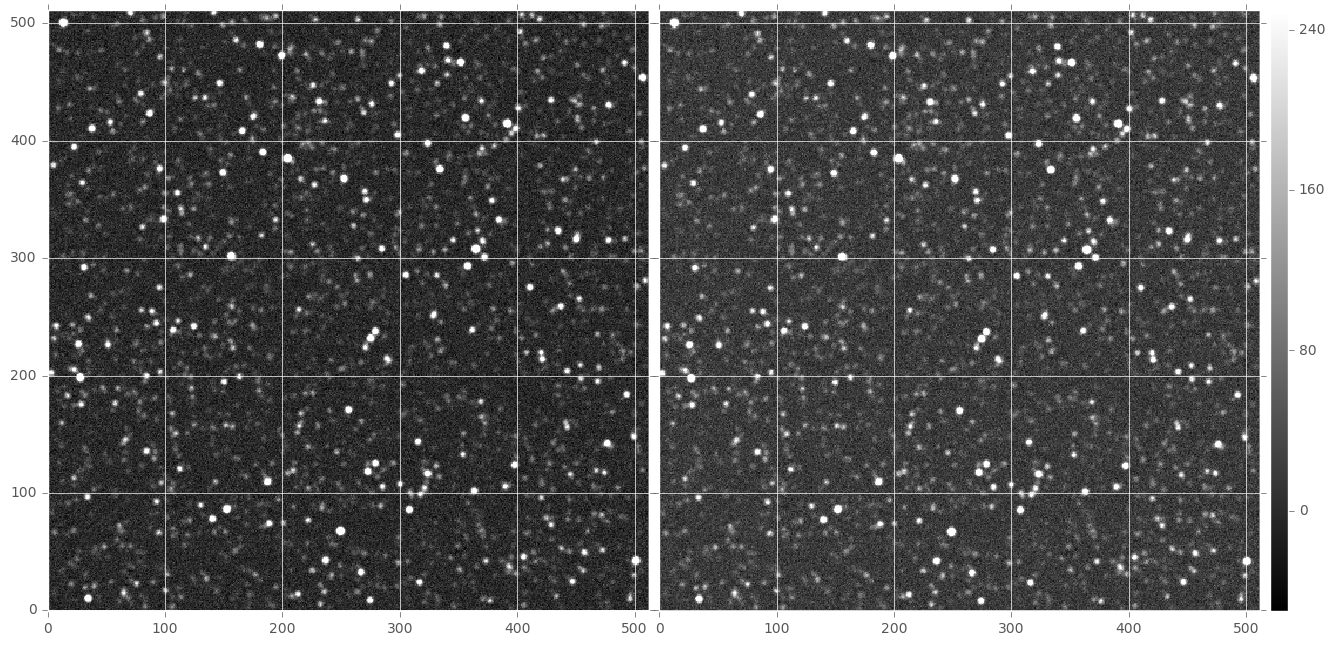

In [20]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(newExp.getMaskedImage().getImage().getArray())
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray()-newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage(), newExp.getMaskedImage().getImage()), clim=(-50,250), imScale=8)

stats(mean=-20.0, stdev=0.0, min=-20.0, max=-20.0)


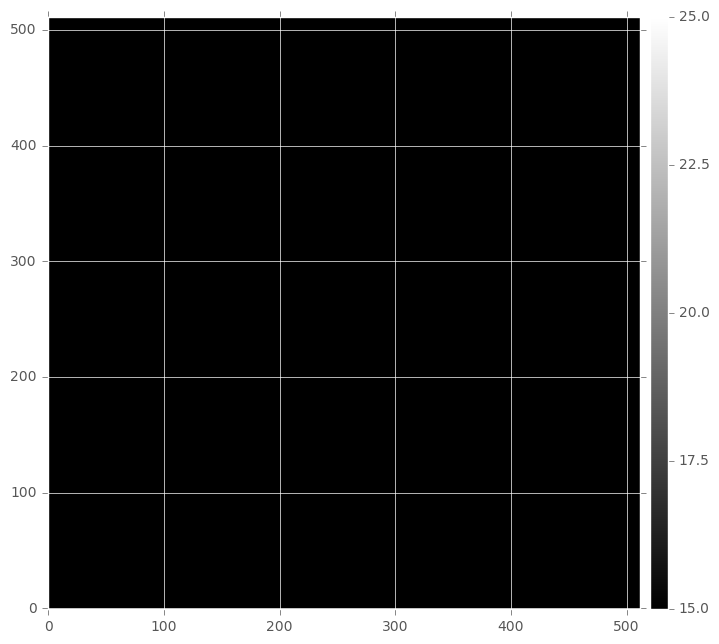

In [21]:
print dit.computeClippedImageStats(exposure.getMaskedImage().getImage().getArray() - \
                   newExp.getMaskedImage().getImage().getArray())
dit.plotImageGrid((exposure.getMaskedImage().getImage().getArray() - \
                   newExp.getMaskedImage().getImage().getArray(),), clim=(15, 25), imScale=8)

In [73]:
# Taken from testImageMapReduce.py

import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg

class GetMeanImageMapperSubtask(ipDiffim.ImageMapperSubtask):
    ConfigClass = ipDiffim.ImageMapperSubtaskConfig  # Doesn't need its own config
    _DefaultName = "ip_diffim_GetMeanImageMapperSubtask"

    def run(self, subExposure, expandedSubExp, fullBBox, **kwargs):
        subArr = subExposure.getMaskedImage() #.getImage().getArray()
        statsControl = afwMath.StatisticsControl()
        statObj = afwMath.makeStatistics(subArr, afwMath.MEAN)
        return statObj.getValue()
        #return subArr.mean()

class GetMeanImageMapReduceConfig(ipDiffim.ImageMapReduceConfig):
    mapperSubtask = pexConfig.ConfigurableField(
        doc="Mapper subtask to run on each subimage",
        target=GetMeanImageMapperSubtask,
    )

In [74]:
config = GetMeanImageMapReduceConfig()
config.gridStepX = config.gridStepY = 8
config.reducerSubtask.reduceOperation = 'none'
task = ipDiffim.ImageMapReduceTask(config)
testExposure = afwImage.ExposureF(128, 128)
testExposure.setPsf(measAlg.DoubleGaussianPsf(11, 11, 2.0, 3.7))
testExposure.getMaskedImage().set(1.234)
subMeans = task.run(testExposure)
firstPixel = testExposure.getMaskedImage().getImage().getArray()[0, 0]
print firstPixel, np.array(subMeans) - firstPixel

1.234 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [64]:
print firstPixel, np.mean(testExposure.getMaskedImage().getImage().getArray()[:,:])
np.abs((np.mean(testExposure.getMaskedImage().getImage().getArray()[:,:]) - firstPixel)/firstPixel)

1.234 1.234


0.0

In [63]:
import lsst.afw.math as afwMath
statsControl = afwMath.StatisticsControl()
statObj = afwMath.makeStatistics(testExposure.getMaskedImage(), afwMath.MEAN)
np.abs(firstPixel - statObj.getValue())/firstPixel

0.0